In [1]:
%env CUDA_VISIBLE_DEVICES = 4

env: CUDA_VISIBLE_DEVICES=4


In [15]:
%load_ext autoreload
%autoreload 2
import os
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])
sys.path.extend(['..'])

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from torchcfm.conditional_flow_matching import *
from physics_flow_matching.unet.unet import GuidedUNetModelWrapper as UNetModel
from physics_flow_matching.inference_scripts.utils import grad_cost_func_parallel, cost_func_parallel, sample_noise
from physics_flow_matching.inference_scripts.cond import infer_parallel
from physics_flow_matching.inference_scripts.uncond import infer
from physics_flow_matching.multi_fidelity.synthetic.dists.base import get_distribution
from physics_flow_matching.inference_scripts.cond import d_flow, d_flow_ssag, infer_grad, infer_gradfree, flow_daps, infer_grad_dpmc
from physics_flow_matching.inference_scripts.utils import cost_func, cost_func_exp, ssag_get_norm_params, ssag_sample, sample_noise, grad_cost_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = np.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/synthetic/turb/turb_128_.npy")
test_data = np.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/synthetic/turb/turb_128_test_.npy")
m, std = data.mean(axis=(0,2,3), keepdims=True), data.std(axis=(0,2,3), keepdims=True)
X = (test_data - m)/std

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def meas_func(x, **kwargs):
    return x[..., :64, :]

In [6]:
meas = torch.from_numpy(meas_func(X)).to(device)

In [7]:
exp = 2
iteration = 0
print(f"Loading model for experiment {exp}, iteration {iteration}")
ot_cfm_model = UNetModel(dim=[3, 128, 128],
                        channel_mult="1, 1, 2, 3, 4",
                        num_channels=64,
                        num_res_blocks=2,
                        num_head_channels=64,
                        attention_resolutions="32, 16, 8",
                        dropout=0.0,
                        use_new_attention_order=True,
                        use_scale_shift_norm=True,
                        )
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/vf_fm/exps/downsampled_turb/exp_{exp}/saved_state/checkpoint_{iteration}.pth")
ot_cfm_model.load_state_dict(state["model_state_dict"])
ot_cfm_model.to(device)
ot_cfm_model.eval();

Loading model for experiment 2, iteration 0


### Grad

In [12]:
total_samples = 10
samples_per_batch = 1
scale = 1
sample_shape = (3,128,128)
initial_points = torch.randn(total_samples, *sample_shape).to(device)

In [13]:
cond = meas[3:4].to(device).repeat(total_samples,1,1,1)
# cond = meas[1:2].repeat(total_samples,1,1,1).to(device)
# cond += 0.10 * torch.randn_like(cond)

In [ ]:
samples_cond_grad = infer_parallel(cfm_model=ot_cfm_model,
                    swag=False, samples_per_batch=samples_per_batch, total_samples=total_samples,
                    dims_of_img=(3,128,128), num_of_steps=300, grad_cost_func=grad_cost_func_parallel, meas_func= meas_func,
                    conditioning=cond, conditioning_scale=scale, device=device, refine=1, sample_noise=sample_noise,
                    use_heavy_noise=False, rf_start=False,
                    solver='euler', is_grad_free=False, nu=None)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/meet/.conda/envs/torchcfm/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")
100%|██████████| 10/10 [54:44<00:00, 328.46s/it]


In [ ]:
samples = samples_cond_grad * std + m

In [ ]:
# np.save(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/analysis/inverse_problems/turb/meas_func1/samples_grad_scale_{scale}_itr_{iteration}_same_meas", samples)

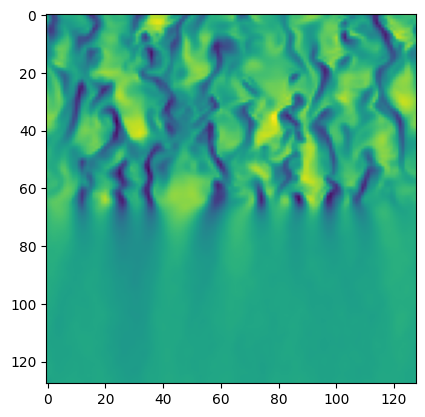

In [ ]:
plt.figure()
plt.imshow(samples_cond_grad[:,0].mean(axis=0))
plt.show()

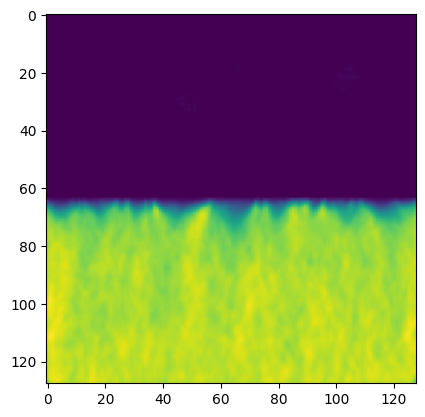

In [ ]:
plt.figure()
plt.imshow(samples_cond_grad[:,0].std(axis=0))
plt.show()

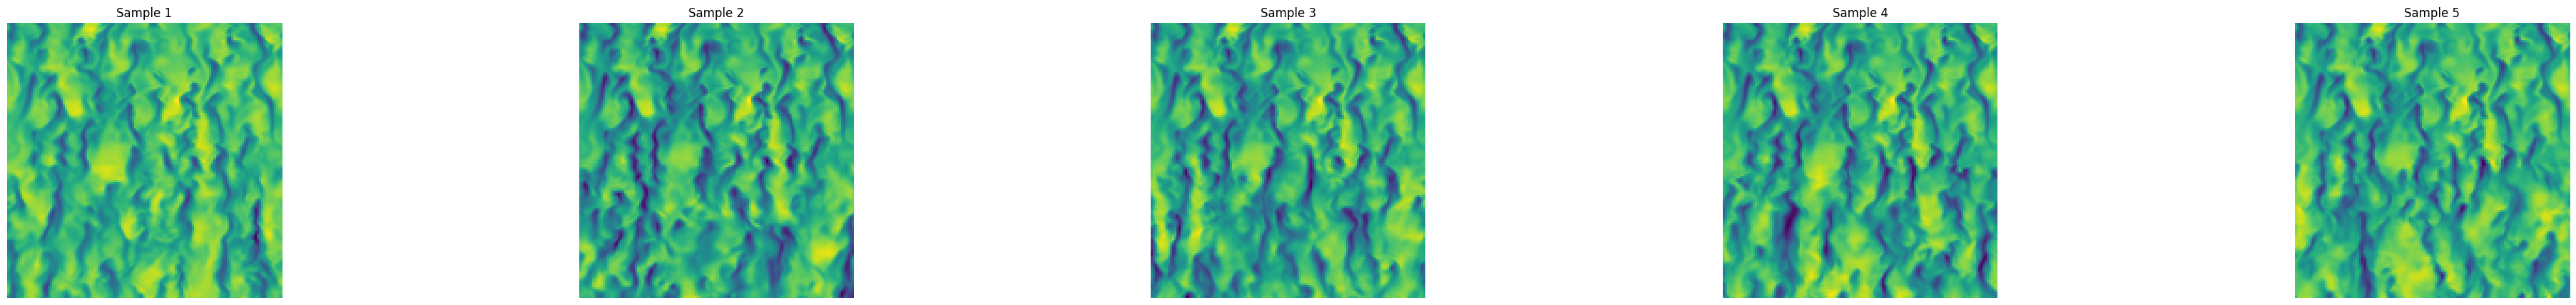

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(50, 5))
for i in range(5):
    axes[i].imshow(samples_cond_grad[i, 0])
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')

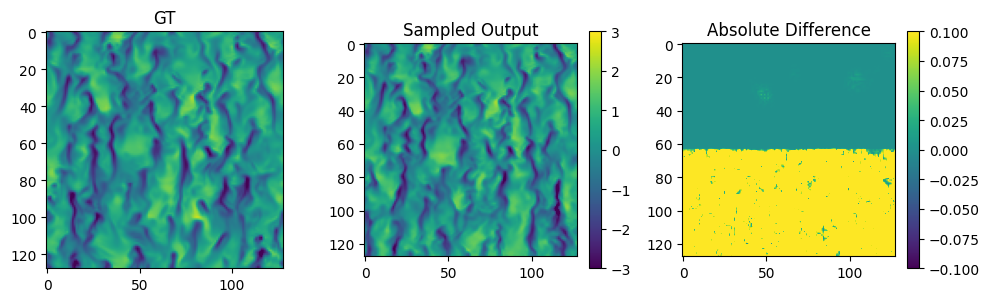

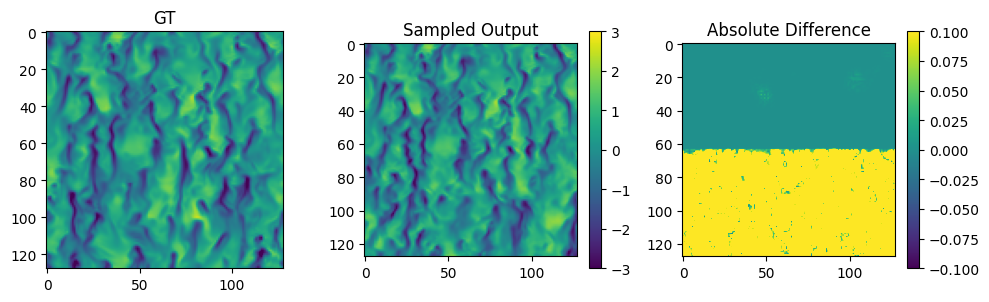

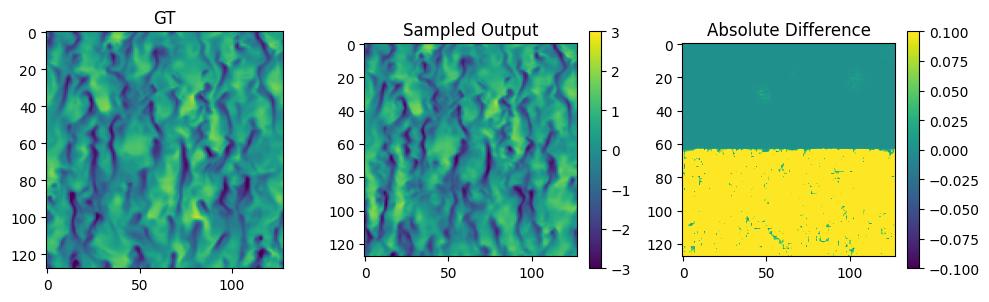

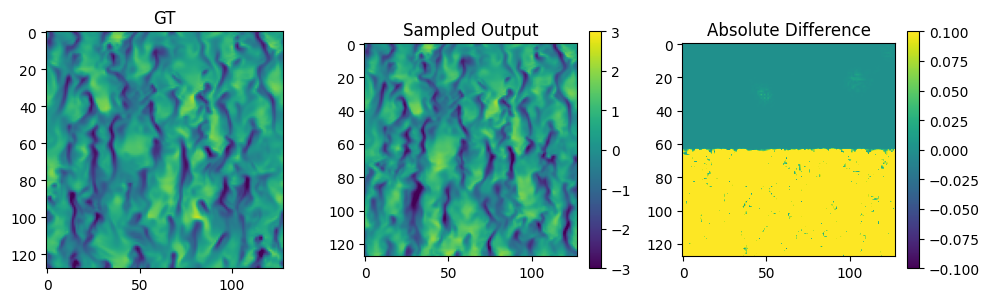

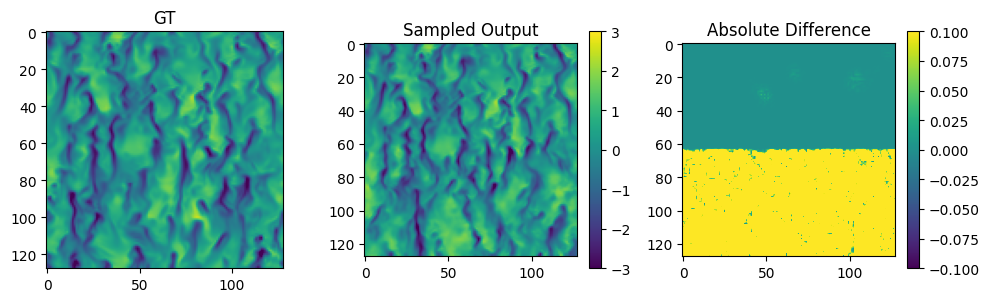

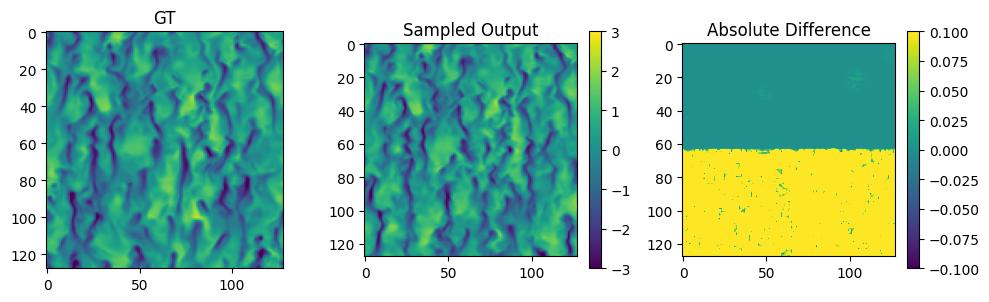

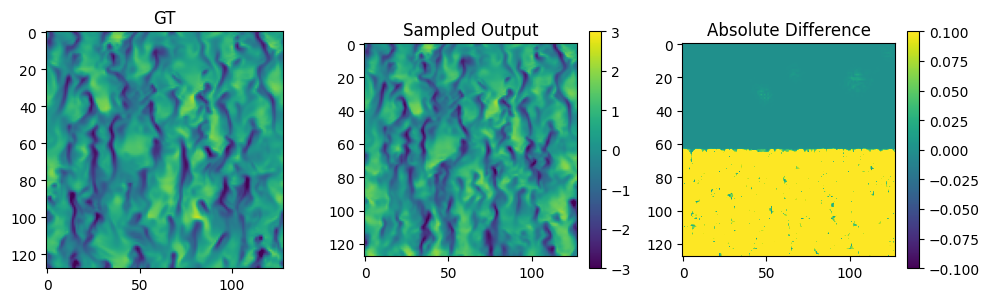

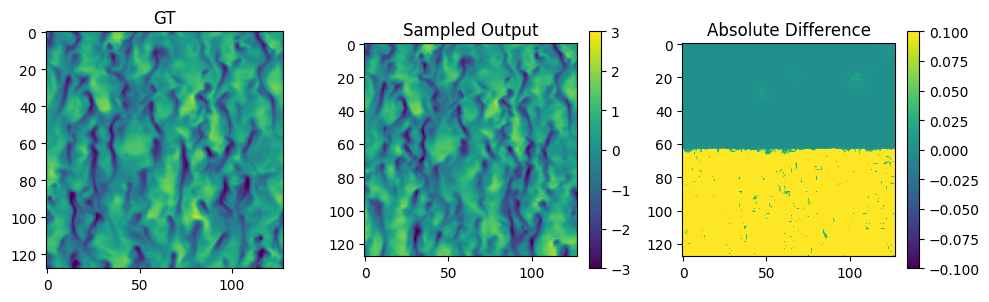

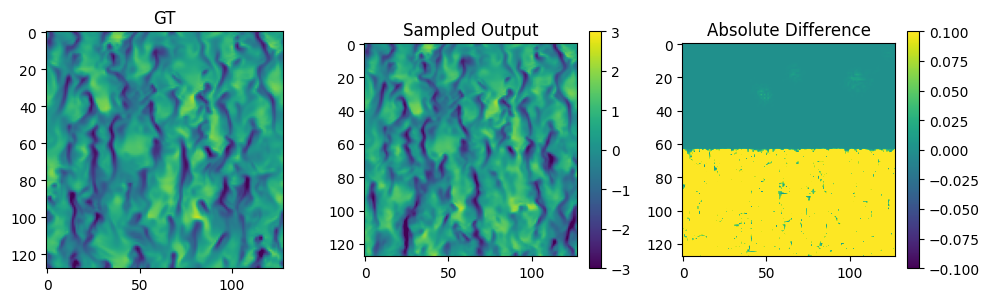

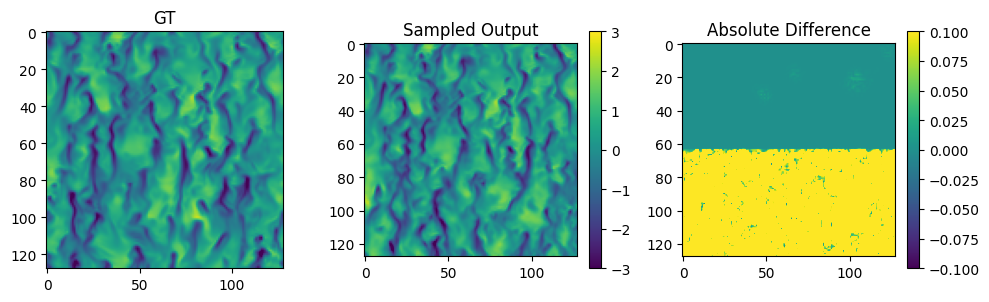

In [ ]:
for i in range(10):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(X[3, 0], vmax=3, vmin=-3)
    axes[0].set_title('GT')
    a = axes[1].imshow(samples_cond_grad[i, 0], vmax=3, vmin=-3)
    axes[1].set_title('Sampled Output')
    fig.colorbar(ax=axes[1], mappable=a, fraction = 0.05)
    b = axes[2].imshow(np.abs(X[3, 0] - samples_cond_grad[i, 0]), vmax=0.1, vmin=-0.1)
    axes[2].set_title('Absolute Difference')
    fig.colorbar(ax=axes[2], mappable=b, fraction = 0.05)
    plt.tight_layout()
    plt.show()

In [ ]:
np.square((meas[3:4].cpu().numpy() - samples_cond_grad[..., :64, :])).mean()

np.float32(6.215997e-06)

# DPMC

In [16]:
samples_cond_grad_dpmc = infer_grad_dpmc(
        fm=FlowMatcher(sigma=1e-3), cfm_model=ot_cfm_model,
        samples_per_batch=1, 
        total_samples=total_samples,
        dims_of_img=(3,128,128), 
        num_of_steps=100, 
        grad_cost_func=grad_cost_func, 
        meas_func=meas_func,
        conditioning=cond,
        conditioning_scale=1, 
        refine=5,               
        rf_start=False,         
        device=device,
        swag = False,
        eta=torch.linspace(1e-6, 1e-8, 100), 
        sample_noise=sample_noise, 
        use_heavy_noise=False, 
        start_provided=True, 
        start_point=initial_points,

    )

100%|██████████| 99/99 [00:04<00:00, 20.99it/s, distance=6.29e-5] 


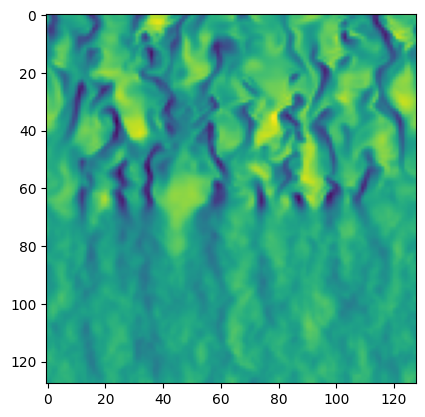

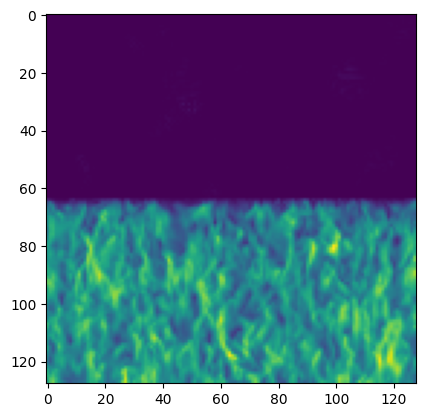

In [19]:
samples = samples_cond_grad_dpmc * std + m
plt.figure()
plt.imshow(samples_cond_grad_dpmc[:,0].mean(axis=0))
plt.show()
plt.figure()
plt.imshow(samples_cond_grad_dpmc[:,0].std(axis=0))
plt.show()

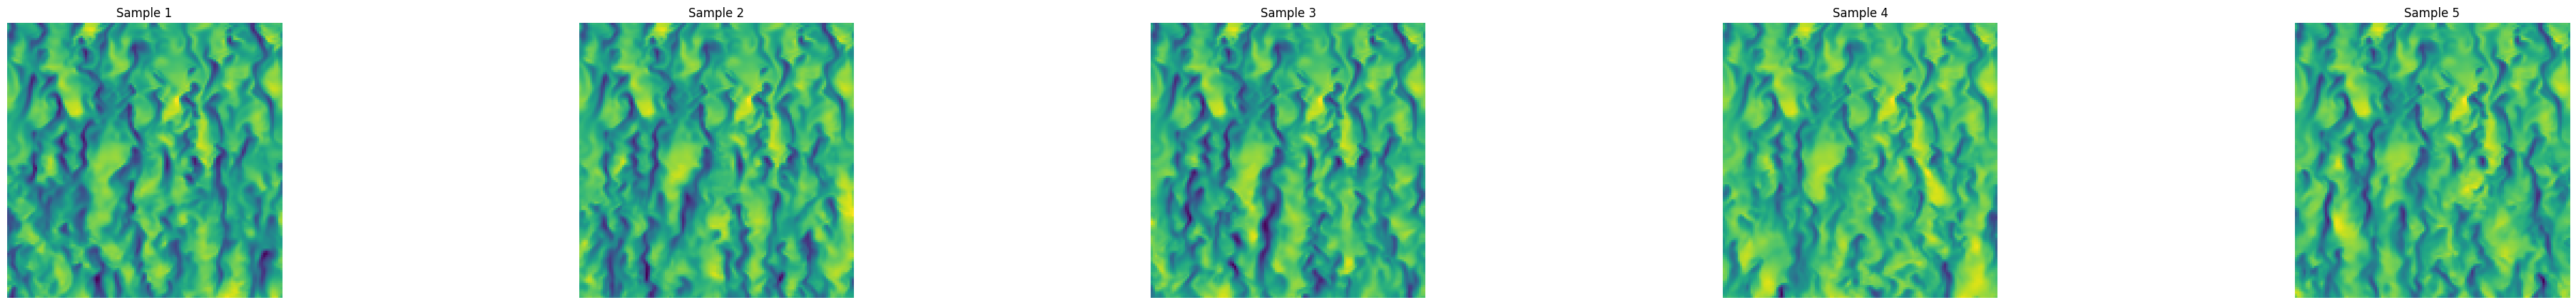

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(50, 5))
for i in range(5):
    axes[i].imshow(samples_cond_grad_dpmc[i, 0])
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')

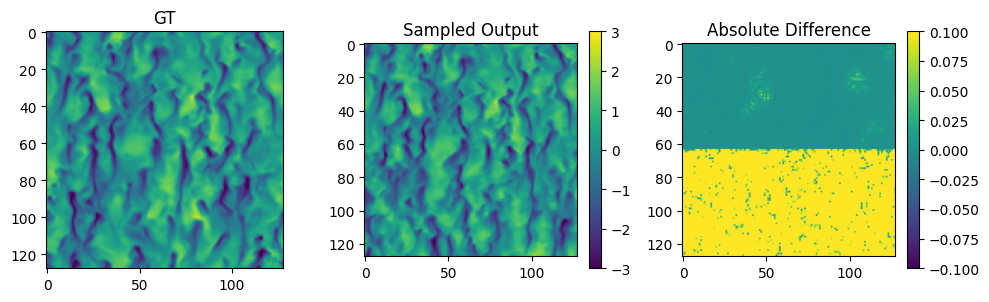

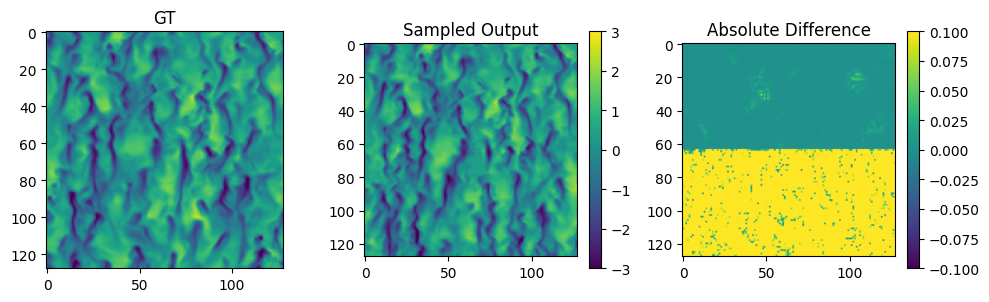

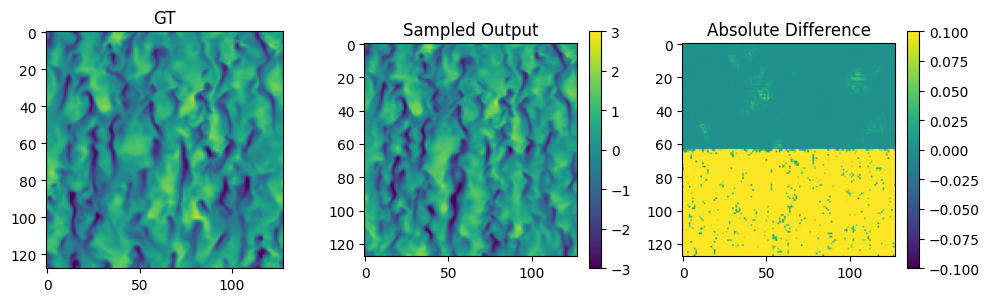

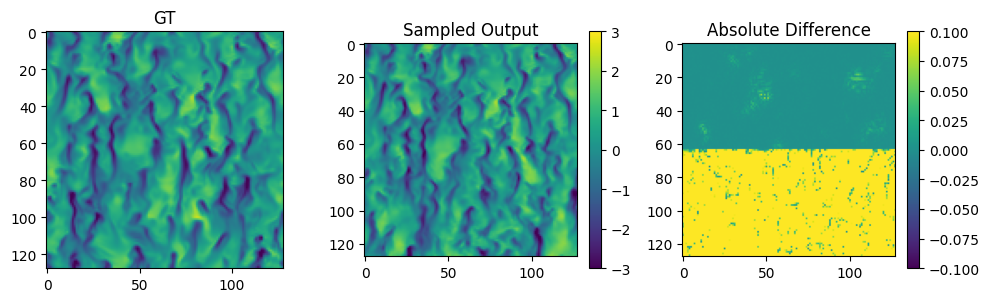

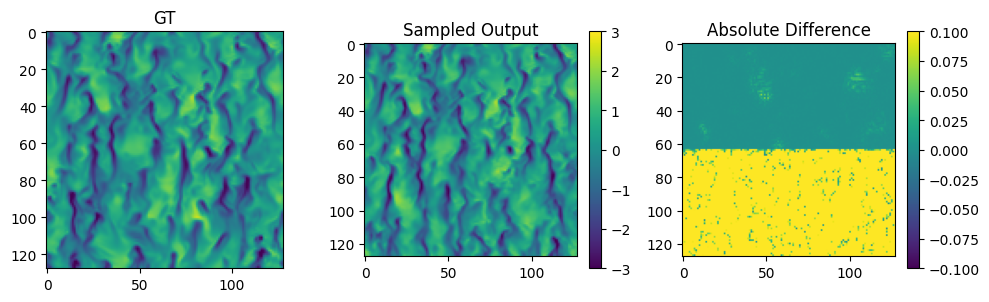

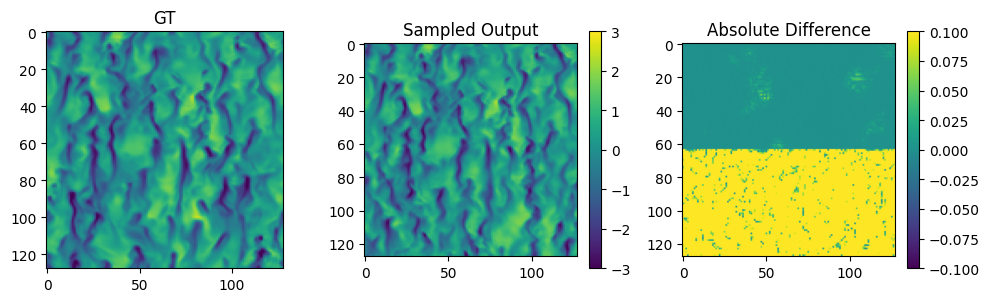

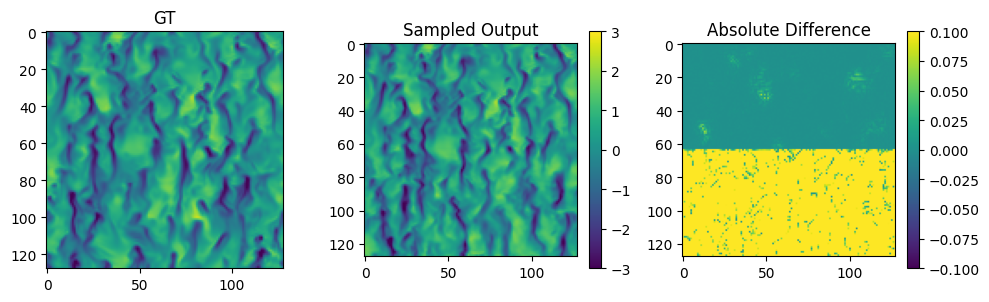

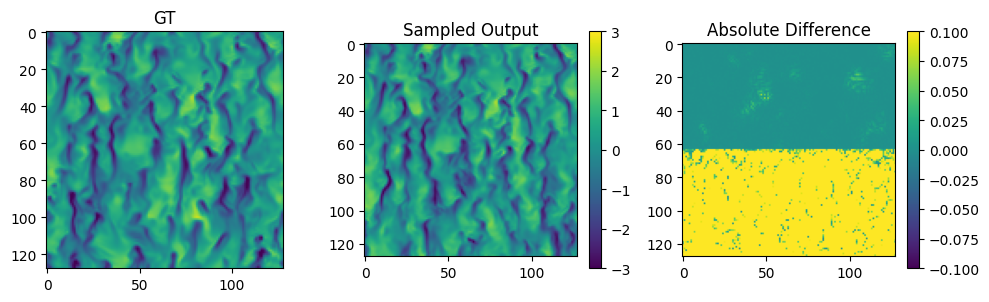

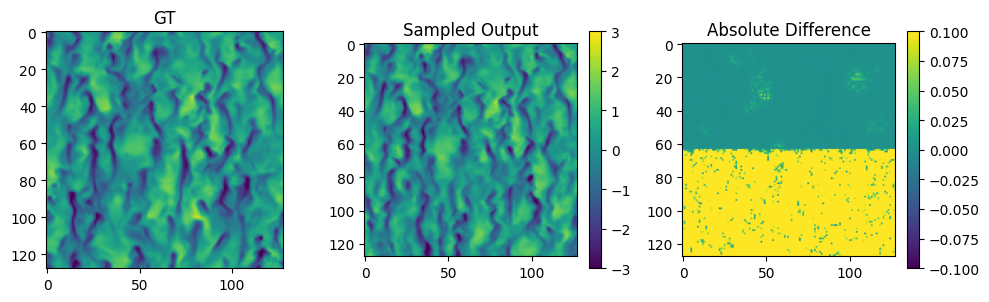

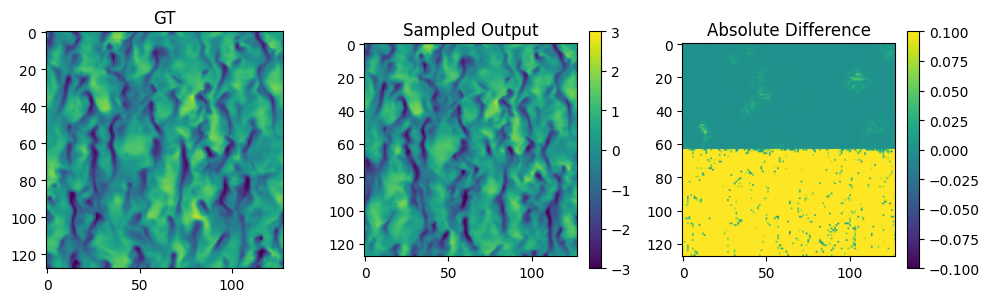

In [22]:
for i in range(10):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(X[3, 0], vmax=3, vmin=-3)
    axes[0].set_title('GT')
    a = axes[1].imshow(samples_cond_grad_dpmc[i, 0], vmax=3, vmin=-3)
    axes[1].set_title('Sampled Output')
    fig.colorbar(ax=axes[1], mappable=a, fraction = 0.05)
    b = axes[2].imshow(np.abs(X[3, 0] - samples_cond_grad_dpmc[i, 0]), vmax=0.1, vmin=-0.1)
    axes[2].set_title('Absolute Difference')
    fig.colorbar(ax=axes[2], mappable=b, fraction = 0.05)
    plt.tight_layout()
    plt.show()

In [24]:
np.square((meas[3:4].cpu().numpy() - samples_cond_grad_dpmc[..., :64, :])).mean()

np.float32(5.6796158e-05)

## Check noise sample

In [ ]:
# reverse_init = (np.load("/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/analysis/inverse_problems/turb/meas_func1/samples_grad_scale_1_itr_0.npy") - m) /std

In [ ]:
# plt.imshow(reverse_init[0,0])

In [ ]:
# noise_init =  infer(dims_of_img=(3, 128, 128), total_samples=500, samples_per_batch=100,
#                 use_odeint=True, cfm_model=ot_cfm_model, 
#                 t_start=1., t_end=0., scale=False, device=device,
#                 method="dopri5", use_heavy_noise=False, nu=3, y0_provided=True, y0=torch.from_numpy(reverse_init).to(device))

In [ ]:
# np.save("/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/analysis/inverse_problems/turb/meas_func1/grad_noise_scale_1.npy", noise_init)

In [ ]:
# noise_init.std(axis=(0,2,3)), noise_init.mean(axis=(0,2,3))

In [ ]:
# for i in range(1):
#     plt.figure()
#     plt.imshow(noise_init[:,0].mean(axis=0))
#     plt.show()

In [ ]:
# for i in range(1):
#     plt.figure()
#     plt.imshow(noise_init[:,0].std(axis=0))
#     plt.show()